In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import tensorflow as tf

In [26]:
dimension=512
half_dim=int(dimension/2)
wdw=int(dimension/4)
wdwdw=int(dimension/4*3)

In [27]:
def leaky_relu(inp, alpha=0.2):
    return tf.maximum(inp * alpha, inp)

In [28]:
data_directory='/n/projects/smc/public/SMC/DLRegistration/'

In [29]:
img=plt.imread(data_directory+'Example.tif')
img=sp.misc.imresize(img, [dimension,dimension])

/scratch/smc/anaconda3/envs/tflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


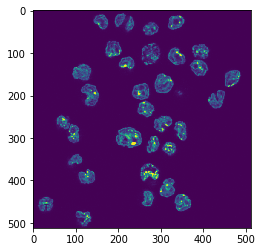

In [30]:
plt.imshow(img)

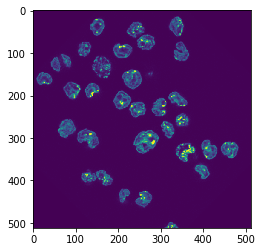

In [31]:
plt.imshow(sp.ndimage.rotate(img, 45, reshape=False))

In [32]:
def generate_batch(batch_size, rotation_range, shifting_range):
    rotates=np.random.uniform(-rotation_range,rotation_range, size=batch_size)
    shifts=np.random.uniform(-shifting_range,shifting_range, size=[batch_size,2])

    truth=np.stack([rotates, shifts[:,0], shifts[:,1]], axis=1)
    dat=np.stack([sp.ndimage.rotate(sp.ndimage.shift(img, truth[n,1:3]), truth[n,0], reshape=False ) for n in range(0,batch_size)])

    data=np.ndarray([batch_size,dimension,dimension,2])
    data[:,:,:,0]=dat
    data[:,:,:,1]=img
    data=data[:,wdw:wdwdw, wdw:wdwdw,:]
    return (data, truth)

In [35]:
remake=True

training_data=0
training_truth=0
if remake:
    training_data, training_truth=generate_batch(10000,180,100)
    np.save(data_directory+'training_data', training_data)
    np.save(data_directory+'training_truth', training_truth)
else:
    training_data=np.load(data_directory+'training_data.npy')
    training_truth=np.load(data_directory+'training_truth.npy')

In [36]:
validation_data,validation_truth=generate_batch(100,180,100)

In [45]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, half_dim,half_dim,2])
y=tf.placeholder(dtype=tf.float32, shape=[None,3])

lr=tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')

xr=x
yr=y

base_scaler=16

A1=leaky_relu(tf.layers.conv2d(xr, base_scaler, [3,3], padding='SAME', dilation_rate=1))
A2=leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME', dilation_rate=2))
A3=leaky_relu(tf.layers.conv2d(A2, base_scaler, [3,3], padding='SAME', dilation_rate=3))
A4=leaky_relu(tf.layers.conv2d(A3, base_scaler, [3,3], padding='SAME', dilation_rate=4))
#A5=leaky_relu(tf.layers.conv2d(A4, base_scaler, [3,1], padding='SAME', dilation_rate=5))
#A6=leaky_relu(tf.layers.conv2d(A5, base_scaler, [3,1], padding='SAME', dilation_rate=6))

#Going down
B0=tf.nn.max_pool(A4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(A4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=leaky_relu(tf.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME'))
E2=leaky_relu(tf.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME'))

F0=tf.nn.max_pool(E2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
F1=leaky_relu(tf.layers.conv2d(F0, 16*base_scaler, [3,3], padding='SAME'))
F2=leaky_relu(tf.layers.conv2d(F1, 16*base_scaler, [3,3], padding='SAME'))

G0=tf.nn.max_pool(F2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
G1=leaky_relu(tf.layers.conv2d(G0, 16*base_scaler, [3,3], padding='SAME'))
G2=leaky_relu(tf.layers.conv2d(G1, 16*base_scaler, [3,3], padding='SAME'))

Flat=tf.layers.flatten(B2)

dense1=tf.layers.dense(Flat, units=1024)
dense2=tf.layers.dense(dense1, units=64)
logits=(tf.layers.dense(dense2, units=3))

diff=tf.subtract(yr,logits)
LSQ=tf.multiply(diff,diff)
loss=tf.reduce_mean(LSQ)
train_op=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [ ]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
for f in range(0,5000):
    idx=np.random.choice(training_data.shape[0], replace=False, size=[40])
    cur_train=training_data[idx,:,:,:]
    cur_truth=training_truth[idx,:]
    _,results, losses=sess.run([train_op, logits, loss], feed_dict={x:cur_train, y:cur_truth, lr:0.001})
    if (f%100==0):
        res, valid_loss=sess.run([logits,loss], feed_dict={x:validation_data, y:validation_truth})
        print([f,losses, valid_loss])
    

[0, 5639.289, 78576850.0]
[100, 3774.6294, 5594.474]
[200, 4110.4946, 5396.934]


In [39]:
res, valid_loss=sess.run([logits,loss], feed_dict={x:validation_data, y:validation_truth})

In [43]:
res[5,:]

array([-95.47345 , -24.79604 ,  38.923683], dtype=float32)

In [44]:
validation_truth[5,:]

array([-129.51668004,   -5.27740836,   16.33480225])